In [1]:
import plotly.graph_objects as go
import pandas as pd
import  matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from numpy import array
from tensorflow.keras.utils import plot_model

In [2]:
df=pd.read_excel("TSLA.xlsx",index_col=0,engine='openpyxl')

#some initial data preprocessing for right format
a='%Y-%m-%d %H:%M:%S'
df.time=pd.to_datetime(df.time,format=a,errors='coerce')
df=df[df['time'].notna()]
df=df[::-1].reset_index(drop=True)
df[["open", "high","low","close","volume"]] = df[["open", "high","low","close","volume"]].apply(pd.to_numeric)

In [3]:
df

,time,open,high,low,close,volume
0,2020-08-28 04:05:00,451.9980,451.998,451.9980,451.998,2820
1,2020-08-28 04:10:00,452.0000,452.000,452.0000,452.000,1855
2,2020-08-28 04:25:00,453.5580,453.558,453.5580,453.558,1370
3,2020-08-28 04:35:00,454.0120,454.012,454.0000,454.000,3715
4,2020-08-28 04:50:00,453.6020,453.602,453.5400,453.540,2855
...,...,...,...,...,...,...
45006,2021-08-20 19:40:00,679.9999,680.000,679.9999,680.000,590
45007,2021-08-20 19:45:00,679.9000,679.900,679.8000,679.800,1444
45008,2021-08-20 19:50:00,679.9000,680.000,679.9000,680.000,1039
45009,2021-08-20 19:55:00,680.1000,680.200,680.1000,680.120,1247


In [4]:
df.corr()

,open,high,low,close,volume
open,1.000000,0.999922,0.999932,0.999912,-0.137045
high,0.999922,1.000000,0.999845,0.999922,-0.131496
low,0.999932,0.999845,1.000000,0.999938,-0.142275
close,0.999912,0.999922,0.999938,1.000000,-0.136794
volume,-0.137045,-0.131496,-0.142275,-0.136794,1.000000


In [5]:
df1=df.reset_index()['close']
df2=df.reset_index()['open']
df3=df.reset_index()['high']
df4=df.reset_index()['low']

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

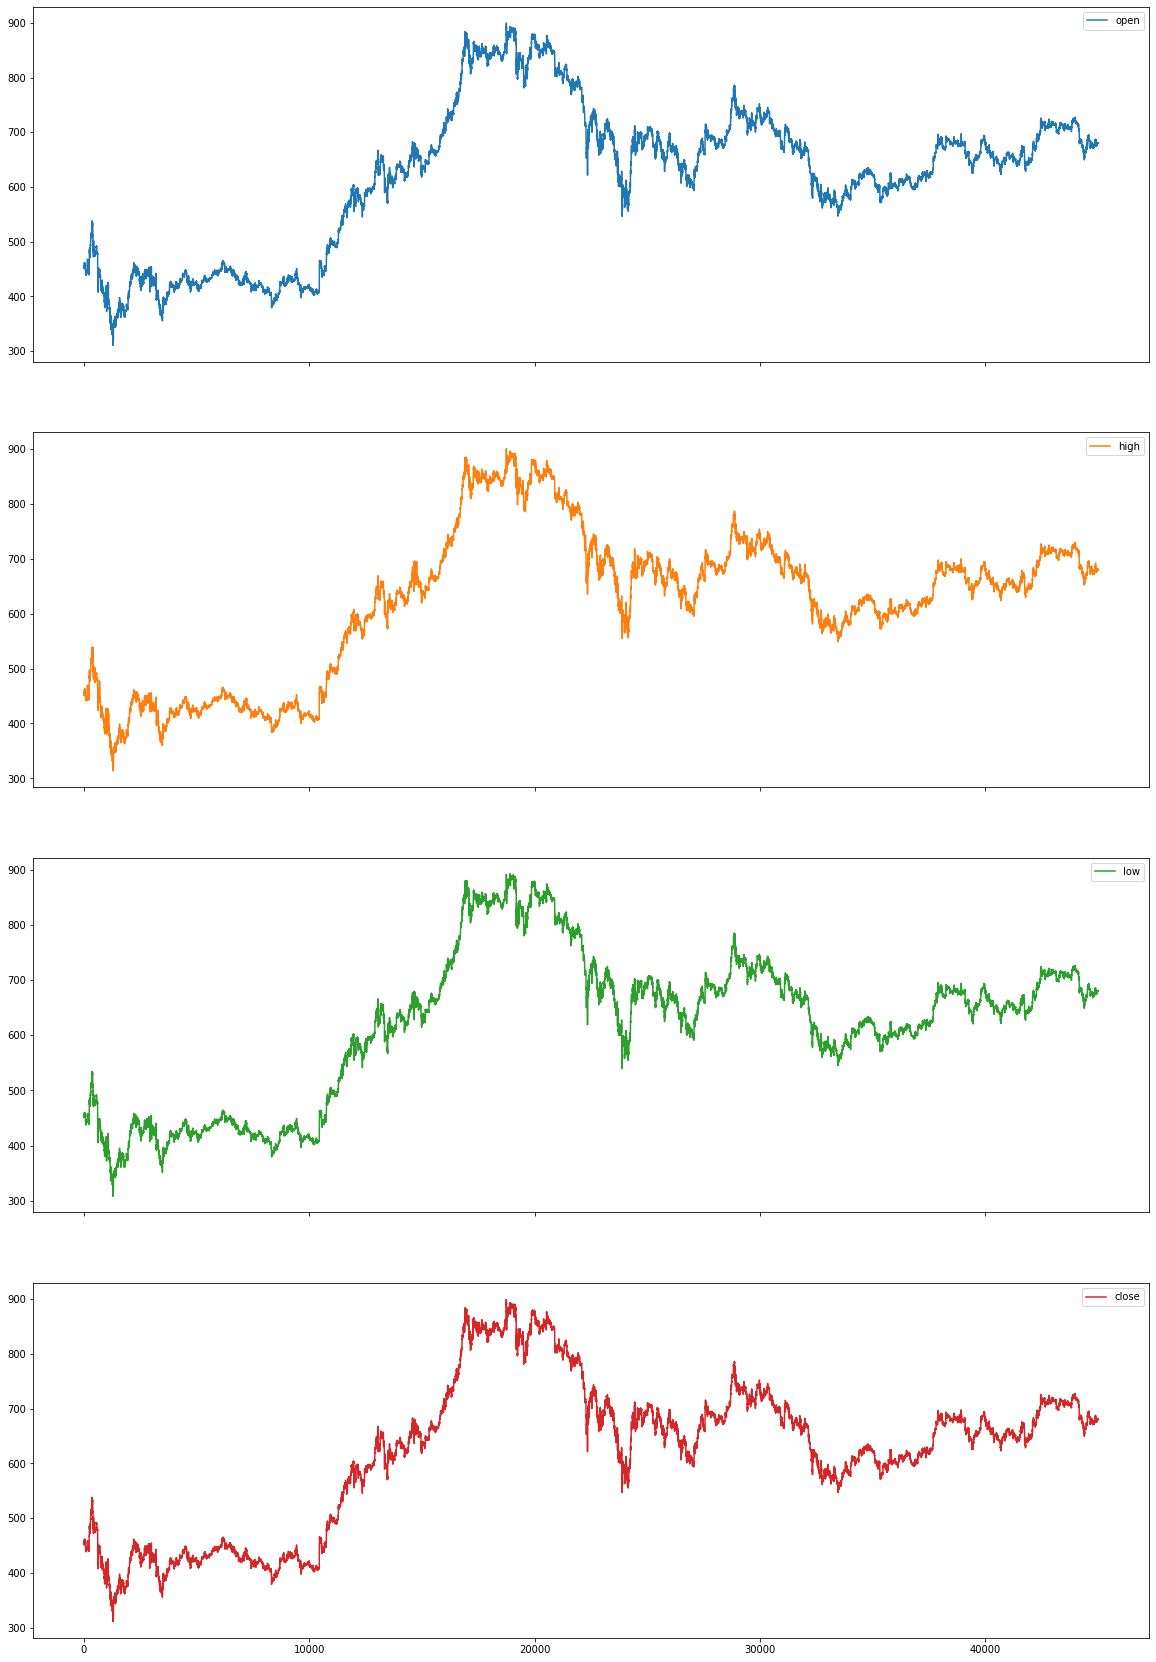

In [6]:
data_df=df.reset_index().drop(columns=['index','volume','time'])
data_df.plot(subplots=True,figsize=(20,30))

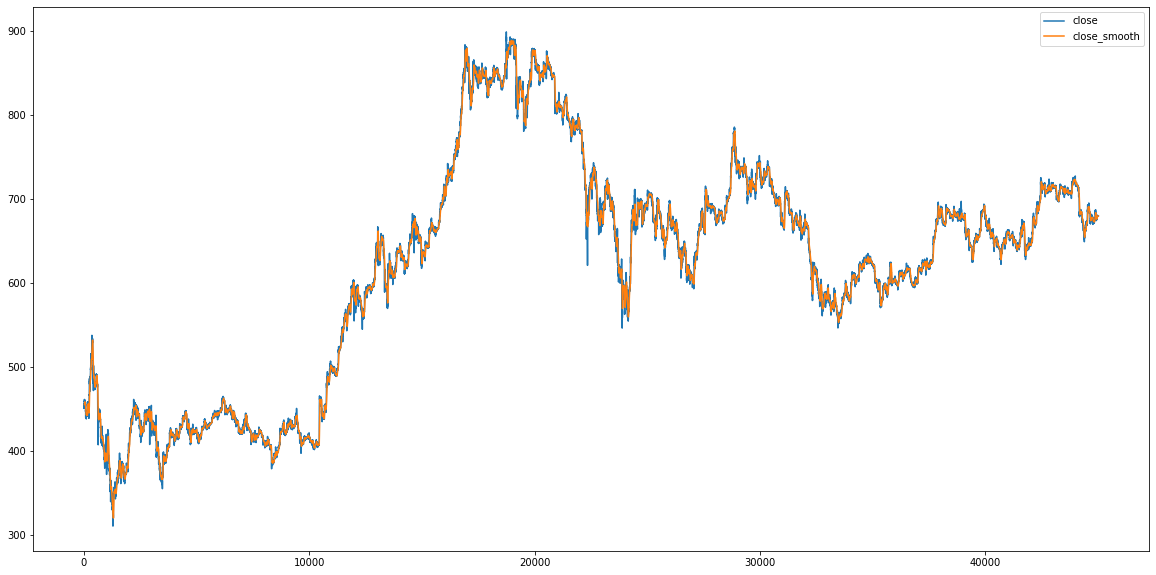

In [7]:
#plotting the smooth rolling mean 
df1=pd.DataFrame(df1)
df1['close_smooth']=df1.rolling(30).mean()
df1.plot(figsize=(20,10))
plt.legend()


In [8]:
df1=df1.reset_index()['close']
df1

0        451.998
1        452.000
2        453.558
3        454.000
4        453.540
          ...   
45006    680.000
45007    679.800
45008    680.000
45009    680.120
45010    680.300
Name: close, Length: 45011, dtype: float64

In [9]:
data_df

,open,high,low,close
0,451.9980,451.998,451.9980,451.998
1,452.0000,452.000,452.0000,452.000
2,453.5580,453.558,453.5580,453.558
3,454.0120,454.012,454.0000,454.000
4,453.6020,453.602,453.5400,453.540
...,...,...,...,...
45006,679.9999,680.000,679.9999,680.000
45007,679.9000,679.900,679.8000,679.800
45008,679.9000,680.000,679.9000,680.000
45009,680.1000,680.200,680.1000,680.120


In [10]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
df_data=scaler.fit_transform(np.array(data_df))

In [11]:
df_data

array([[0.24015352, 0.23552638, 0.24640315, 0.23967427],
       [0.24015691, 0.23552979, 0.24640657, 0.23967767],
       [0.24280268, 0.238186  , 0.24907255, 0.24232602],
       ...,
       [0.62717261, 0.62424346, 0.63637919, 0.62724156],
       [0.62751225, 0.62458443, 0.63672142, 0.62744554],
       [0.62768207, 0.62475492, 0.63655031, 0.62775151]])

In [12]:
##splitting dataset into train and test split
training_size=int(len(df_data)*0.70)
test_size=len(df_data)-training_size
train_data,test_data=df_data[0:training_size,:],df_data[training_size:len(df_data),:]

In [13]:
# #split data into train and training set
# train_data, test_data = df1[:int(len(df1)*0.7)], df1[int(len(df1)*0.7):]
# plt.figure(figsize=(20,10))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Closing Prices')
# plt.plot(train_data, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend()

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 3])    # 0 open 1 high 2 low 3 close
    return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
print(X_test.shape) 
print(y_test.shape)

(13403, 100, 4)
(13403,)


In [17]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(512,activation='relu',return_sequences=True,input_shape=(100,4)))
# model.add(Dropout(0.3))
model.add(LSTM(256,activation='relu'))
model.add(Dropout(0.3))
# model.add(LSTM(64,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2022-05-31 20:46:41.947794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 20:46:41.948107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1058816   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 1,846,529
Trainable params: 1,846,529
Non-trainable params: 0
_________________________________________________________________


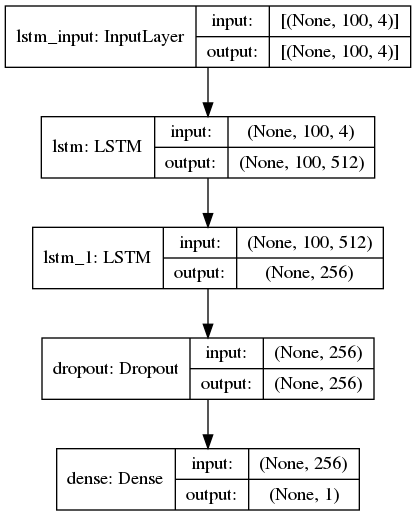

In [19]:
plot_model(model,to_file='timeseriesmodel.png',show_shapes=True,show_layer_names=True)

In [ ]:
r=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=64,verbose=1)

2022-05-31 20:46:42.760706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
 23/491 [>.............................] - ETA: 13:56 - loss: 0.0351

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# make ready the prediction for inverse scalar transform
train_predict=np.repeat(train_predict,X_train.shape[2],axis=-1)
test_predict=np.repeat(test_predict,X_test.shape[2],axis=-1)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)[:,0]
test_predict=scaler.inverse_transform(test_predict)[:,0]

In [ ]:
train_predict

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))


In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(data_df['close'])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1] = test_predict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(data_df['close'],label='actual')
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot,label='predicted')
plt.legend()
plt.show()